### Some last minute tips

Hi, this is just meant to give you a rough idea of how CVXPY works. I.e., what it does. Now CVXPY is pretty fussy and there are many ways to convince it that the problem you are solving is not convex. If you get a DCP error, it means something in your problem formulation has gone amok.

In [1]:
## Usual Imports

import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

Let's start with a simple example of how to CVXPY... really simple. Something we can visualise. Below is the code to make a cute paraboloid. Basically, every z point is just the sum of x^2 and y^2

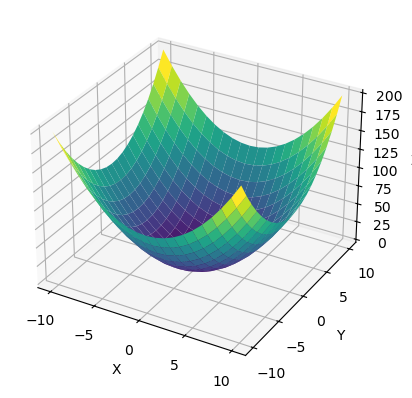

In [9]:
x_s = np.linspace(-10, 10, 21)
x_s_mat = np.tile(x_s, (21, 1))

y_s = np.linspace(-10, 10, 21)
y_s_mat = np.tile(y_s, (21, 1)).T

z_s_mat = np.zeros((21, 21))

for i in range(0, 21):
    for j in range(0, 21):
        z_s_mat[i, j] = x_s_mat[i, j]**2 + y_s_mat[i, j]**2

my_figure = plt.figure()
my_ax = my_figure.add_subplot(111, projection='3d')
my_ax.plot_surface(x_s_mat, y_s_mat, z_s_mat, cmap='viridis')


# Label the axes
my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_zlabel('Z')

plt.show()



Now if I were to simply... I dunno try to minimize the value of z, it would obviously go to zero (x^2 + y^2 is positive but when x and y are zero... it is zero).

In [3]:
x = cp.Variable()
y = cp.Variable()

# The objective is to maximize x-squared plus y-squared
objective = cp.Minimize(x**2 + y**2)

constraints = []

my_prob = cp.Problem(objective, constraints)
my_prob.solve()

0.0

What if I now make the problem a little vexing. Say... place a limitation on the value of x and y. Now x + y must be at least 1. Everything to the top right of the black line below is allowed. Anything else is forbidden.

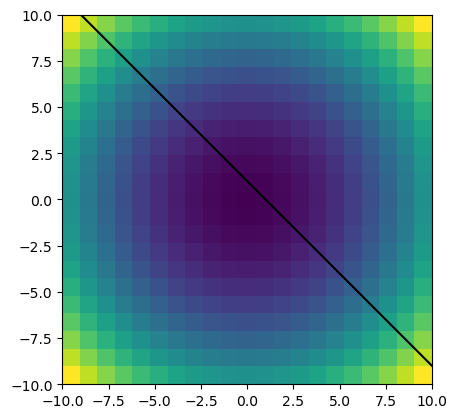

In [4]:
my_fig2 = plt.figure()
plt.imshow(z_s_mat, extent=[-10, 10, -10, 10], cmap='viridis')
plt.plot([-9, 10], [10, -9], 'k')

In [7]:
x = cp.Variable()
y = cp.Variable()

# The objective is to maximize x-squared plus y-squared
objective = cp.Minimize(x**2 + y**2)

constraints = [x + y >= 1]

my_prob = cp.Problem(objective, constraints)
my_prob.solve()

0.5000000000000002

This is as expected. The best-case is when x and y are equal and small (i.e. 0.5 each). 2 * (0.5)^2 is 0.5.

Again pretty easy, but now we can go one further and start to make it a bit non-trivial. Let's change our original function to make is a bit weirder.
Also, lets add multiple constraints.

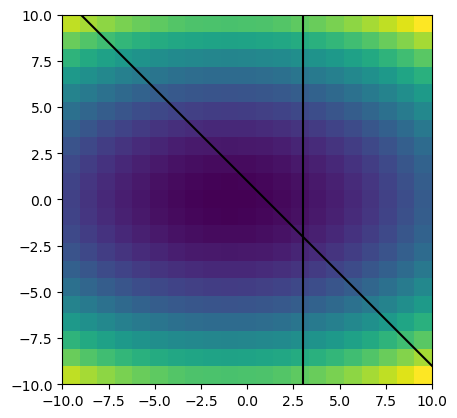

In [10]:

z_s_mat2 = np.zeros((21, 21))

for i in range(0, 21):
    for j in range(0, 21):
        z_s_mat2[i, j] = x_s_mat[i, j]**2 + 3 * y_s_mat[i, j]**2 + 2 * x_s_mat[i, j]

my_fig2 = plt.figure()
plt.imshow(z_s_mat2, extent=[-10, 10, -10, 10], cmap='viridis')
plt.plot([-9, 10], [10, -9], 'k')
plt.plot([3, 3], [-10, 10], 'k')

Now we're going to aim. For the bottom right triangle-shape. This requires... x + y <= 1 and x >=3.

In [17]:
x = cp.Variable()
y = cp.Variable()

# The objective is to maximize x-squared plus y-squared
objective = cp.Minimize(x**2 + 3 * y**2 + 2 * x)

constraints = [x + y <= 1, x >= 3]

my_prob = cp.Problem(objective, constraints)
my_prob.solve()

27.0

Let's work this out. x >= 3 so lets set it to 3. That makes the expression... 3^2 + 2 * 3 + 3 * y^2 = 15 + 3 * y^2

So far so good. Now, we can probably deduce from the other condition that y = -2. Which gives... 27 in total. WOOO!

### Matrix time

Dealing with vectors is just a little bit more difficult conceptually. Trying to plot 4D things doesn't work sadly. Let's work through this slightly more complex example to see what is what.

In [21]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate a random non-trivial quadratic program.
m = 15
n = 10
p = 5

# For repeatability
np.random.seed(1)

# A glorious 10 * 10 matrix... which is multiplied by itself to make it symmetrical (a requirement of using the quad_form matrix)
# The P_squared here must be positive semidefinite (which basically is needed to ensure convexity - a rabbithole)
P = np.random.randn(n, n)
P_squared = P.T @ P

# This just represents the linear part. Each q is multiplied by x. q1 * x1 + q2 * x2 ...
lin_coeff = np.random.randn(n)

# This is a series of constraints, described in matrix form. If you do the math, this is the equivalent of:
# a1 * x1 + a2 * x2 + ...
# Then another
# b1 * x1 + b2 * x2 + ...
ineq_const = np.random.randn(m, n)

# This goes with the above line... there is one of these per equation.
ineq_comp = ineq_const @ np.random.randn(n)

# Taken together, we get:
# a1 * x1 + a2 * x2 + ... + an * xn <= A
# b1 * x1 + b2 * x2 + ... + bn * xn <= B

# The below is the same, but for equality constraints which are really just inequalities which go... both ways!
A = np.random.randn(p, n)
b = np.random.randn(p)

# X here is our ten-dimensionsal optimisation space
x = cp.Variable(n)

prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P_squared) + lin_coeff.T @ x),
                 [ineq_const @ x <= ineq_comp, A @ x == b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)


The optimal value is 86.89141585569908
A solution x is
[-1.68244521  0.29769913 -2.38772183 -2.79986015  1.18270433 -0.20911897
 -4.50993526  3.76683701 -0.45770675 -3.78589638]
A dual solution corresponding to the inequality constraints is
[ 0.          0.          0.          0.          0.         10.45538054
  0.          0.          0.         39.67365045  0.          0.
  0.         20.79927156  6.54115873]
